# Tabular Montecarlo First Visit and Every Visit Implementation

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

def create_env():
    #return gym.make('FrozenLake-v1', is_slippery=False)  # or True, depending on your use case
    return gym.make('FrozenLake-v1', is_slippery=False)

def initialize_q_table(env):
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    return np.zeros((number_of_states, number_of_actions))

# Decay function for epsilon
def decay_function(episode, total_train_episodes, min_epsilon, current_epsilon):
    return max(min_epsilon, min(1.0, 1.0 - np.log10((episode + 1) / (total_train_episodes * 0.1))))
    

def choose_action(q_table, state, epsilon, env):
    if np.random.random() <= epsilon:
        return env.action_space.sample()  # Exploration
    else:
        return np.argmax(q_table[state])  # Exploitation

def Generate_episode(epsilon, q_table, env, max_env_steps):
    state = env.reset()
    total_reward = 0
    done = False
    trajectory = []
    
    for step in range(max_env_steps):
        if isinstance(state, tuple):
            state = state[0]

        action = choose_action(q_table, state, epsilon, env)
        new_state, reward, done, info, _ = env.step(action)
        trajectory.append([state, action, reward])
        state = new_state
        total_reward += reward
        if done:
            break
    
    return trajectory, total_reward

# Monte Carlo algorithm first visit version
def Monte_Carlo_First_Visit(env, total_train_episodes, gamma, max_epsilon, min_epsilon, current_epsilon):
    q_table = initialize_q_table(env)
    visits_counter = np.zeros_like(q_table)
    rewards = []
    history = np.zeros((total_train_episodes, *q_table.shape))
    max_env_steps = env.spec.max_episode_steps
    epsilons = np.zeros(total_train_episodes)

    for episode in range(total_train_episodes):
        epsilon = decay_function(episode, total_train_episodes, min_epsilon, current_epsilon)
        trajectory, total_reward = Generate_episode(epsilon, q_table, env, max_env_steps)
        G = 0
        gamma = 0.99
        first_visit_check = set()
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            G = gamma * G + reward
            print(f"State: {state}, Action: {action}, Reward: {G}")
            
            if isinstance(state, dict):
                state = state.get('state_key', 0)  
            if isinstance(state, tuple):
                    state = state[0]
            #if visits_counter[state,action]==0:
            if (state,action) not in first_visit_check:
                first_visit_check.add((state,action))
                visits_counter[state, action] += 1
                q_table[state, action] += (G - q_table[state, action]) / visits_counter[state, action]

        history[episode] = q_table
        epsilons[episode] = epsilon
        
        if episode % 100 == 0:
            rewards.append(total_reward)

    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    return q_table,history, epsilons

# Monte Carlo algorithm - Every Visit Version
def Monte_Carlo_Every_Visit(env, total_train_episodes, gamma, max_epsilon, min_epsilon, current_epsilon):
    q_table = initialize_q_table(env)
    visits_counter = np.zeros_like(q_table)
    
    history = np.zeros((total_train_episodes, *q_table.shape))
    epsilons = np.zeros(total_train_episodes)
    
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(total_train_episodes):
        epsilon = decay_function(episode, total_train_episodes, min_epsilon, current_epsilon)
        trajectory, total_reward = Generate_episode(epsilon, q_table, env, max_env_steps)
        G = 0
       
        
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            G = gamma * G + reward
            
            if isinstance(state, dict):
                state = state.get('state_key', 0)  # Adjust 'state_key' to the appropriate key in your dictionary
            
            if isinstance(state, tuple):
                state = state[0]  # Adjust for your state representation

            # every-visit MC    
            visits_counter[state, action] += 1
            q_table[state, action] += (G - q_table[state, action]) / visits_counter[state, action]
        
        history[episode] = q_table
        epsilons[episode] = epsilon
            
    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    return q_table, history, epsilons




# Testing the policy
def test_policy(env, q_table, num_episodes=10):
    rewards = []
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(num_episodes):
        state = env.reset()
        total_rewards = 0
        done = False
        
        for step in range(max_env_steps):
            if isinstance(state, tuple):
                state = state[0]

            action = np.argmax(q_table[state])
            state, reward, done, info, _ = env.step(action)
            total_rewards += reward
            env.render()
            if done:
                env.render()
                break
        
        rewards.append(total_rewards)
        print(f"Episode {episode}, reward {total_rewards}")
    
    print(f"Average score: {np.mean(rewards)}")


    


# First Visit Training and Testing 

In [2]:
# Main code
if __name__ == "__main__":
    n_times = 10 #10 if is_slippery=True
    total_train_episodes = 1000 #50000 if is_slippery=True
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01
    current_epsilon = 1.0   

    env = create_env()

    MC_tables = []
    MC_rewards = []

    for number in range(1):
        #print(f"\n ********** Training number {number}")
        q_table,history, epsilons = Monte_Carlo_First_Visit(env, total_train_episodes, gamma, max_epsilon, min_epsilon, current_epsilon)
      
        
    np.save('ON/imgs/FV_MC_tables.npy', history)
    np.save('ON/models/FV_MC_Q.npy', q_table)
    np.save("On/models/FV_MC_eps.npy", epsilons)
   
  
    
    env.close()


State: 6, Action: 0, Reward: 0.0
State: 10, Action: 3, Reward: 0.0
State: 9, Action: 2, Reward: 0.0
State: 8, Action: 2, Reward: 0.0
State: 8, Action: 0, Reward: 0.0
State: 9, Action: 0, Reward: 0.0
State: 8, Action: 2, Reward: 0.0
State: 8, Action: 0, Reward: 0.0
State: 8, Action: 0, Reward: 0.0
State: 4, Action: 1, Reward: 0.0
State: 4, Action: 0, Reward: 0.0
State: 0, Action: 1, Reward: 0.0
State: 1, Action: 0, Reward: 0.0
State: 1, Action: 3, Reward: 0.0
State: 0, Action: 2, Reward: 0.0
State: 0, Action: 0, Reward: 0.0
State: 0, Action: 0, Reward: 0.0
State: 0, Action: 3, Reward: 0.0
State: 1, Action: 1, Reward: 0.0
State: 0, Action: 2, Reward: 0.0
State: 1, Action: 1, Reward: 0.0
State: 0, Action: 2, Reward: 0.0
State: 0, Action: 3, Reward: 0.0
State: 0, Action: 3, Reward: 0.0
State: 0, Action: 0, Reward: 0.0
State: 0, Action: 3, Reward: 0.0
State: 4, Action: 2, Reward: 0.0
State: 0, Action: 1, Reward: 0.0
State: 0, Action: 3, Reward: 0.0
State: 0, Action: 0, Reward: 0.0
State: 4,

(1000,)


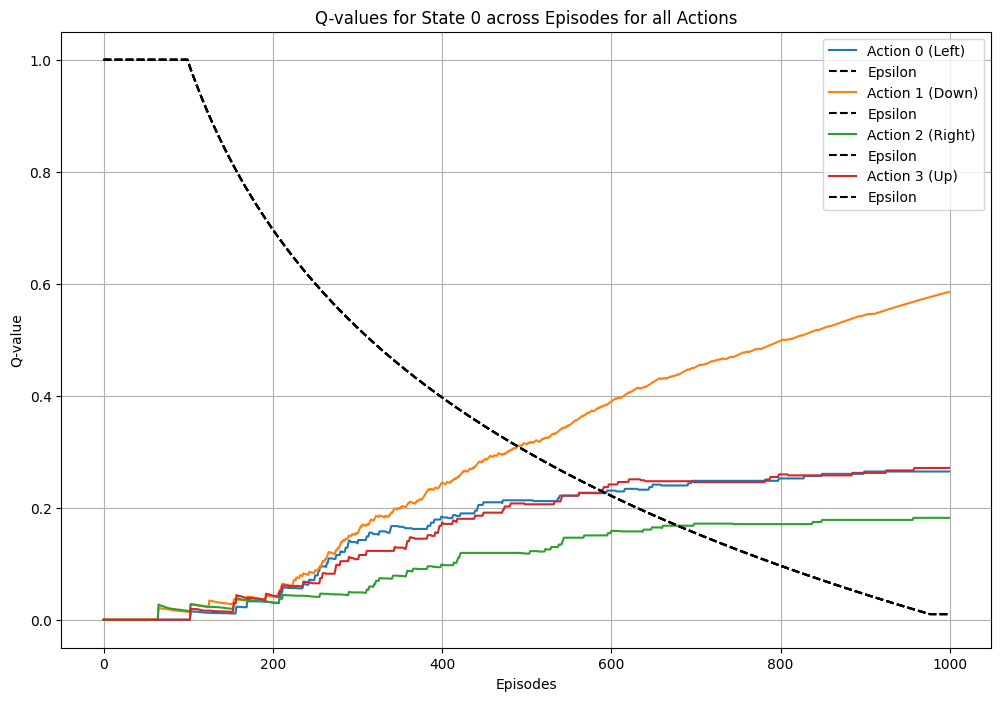

In [3]:

# Load the history of Q-tables across episodes
history = np.load('ON/imgs/FV_MC_tables.npy')
epsilons = np.load('ON/models/FV_MC_eps.npy')
print(epsilons.shape)
# Select the state you want to plot
state = 0  # Example: state 0

# Number of actions (assuming 4 actions as in FrozenLake)
num_actions = history.shape[2]
action_labels = {
    0: 'Left',
    1: 'Down',
    2: 'Right',
    3: 'Up'
}


# Plot the values for all actions
plt.figure(figsize=(12, 8))
for action in range(num_actions):
    # Extract the values of the selected cell (state, action) from each episode
    q_values = history[:, state, action]
    plt.plot(q_values, label=f'Action {action} ({action_labels[action]})')
    plt.plot(epsilons, label='Epsilon', color='black', linestyle='--')

plt.title(f"Q-values for State {state} across Episodes for all Actions")
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.legend()
plt.grid(True)
plt.show()

# Every Visit Training and Testing

In [4]:
# Main code
if __name__ == "__main__":
    n_times = 1
    total_train_episodes = 1000
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01
    current_epsilon = 1.0
    
    env = create_env()

    MC_tables = []
    MC_rewards = []

    for number in range(n_times):
        #print(f"\n ********** Training number {number}")
        q_table, history, epsilons = Monte_Carlo_Every_Visit(env, total_train_episodes, gamma, max_epsilon, min_epsilon, current_epsilon)
       

    np.save('ON/imgs/EV_MC_tables.npy', history)
    np.save('ON/models/EV_MC_Q.npy', q_table)
    np.save("ON/models/EV_MC_eps.npy", epsilons)
   
    
    env.close()


Episode 999, epsilon 0.0100, reward 1.00


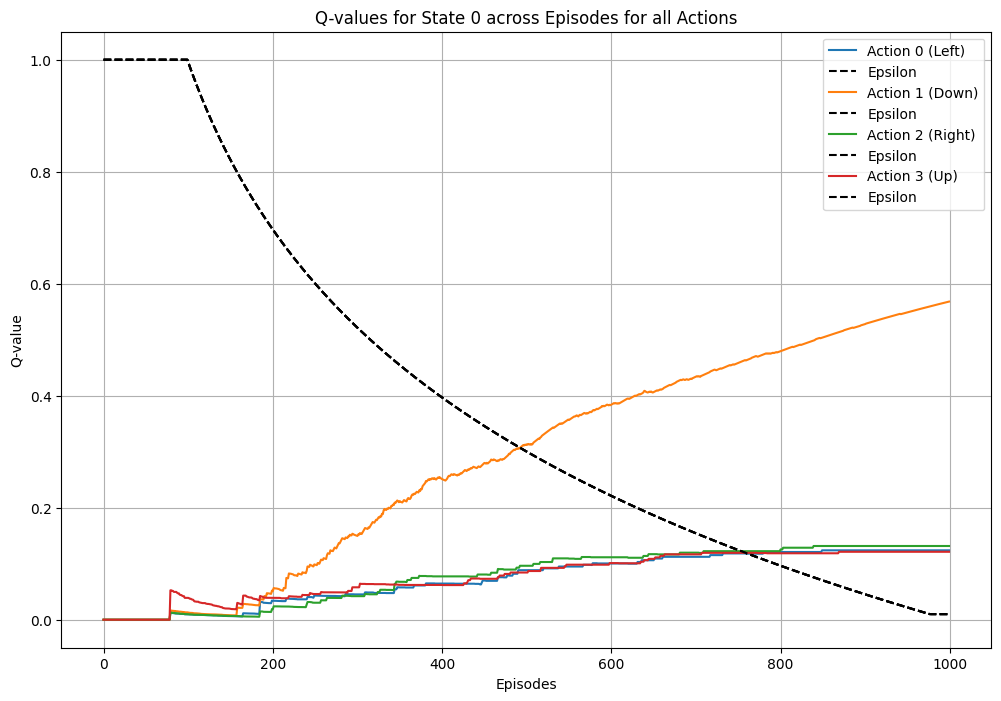

In [5]:

# Load the history of Q-tables across episodes
history = np.load('ON/imgs/EV_MC_tables.npy')
epsilons = np.load('ON/models/EV_MC_eps.npy')

# Select the state you want to plot
state = 0  # Example: state 0

# Number of actions (assuming 4 actions as in FrozenLake)
num_actions = history.shape[2]
action_labels = {
    0: 'Left',
    1: 'Down',
    2: 'Right',
    3: 'Up'
}


# Plot the values for all actions
plt.figure(figsize=(12, 8))
for action in range(num_actions):
    # Extract the values of the selected cell (state, action) from each episode
    q_values = history[:, state, action]
    plt.plot(q_values, label=f'Action {action} ({action_labels[action]})')
    plt.plot(epsilons, label='Epsilon', color='black', linestyle='--')

plt.title(f"Q-values for State {state} across Episodes for all Actions")
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.legend()
plt.grid(True)
plt.show()

# Policy Plot

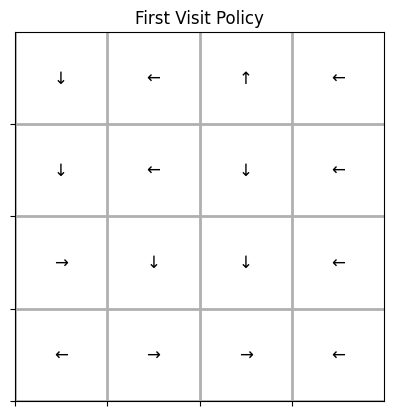

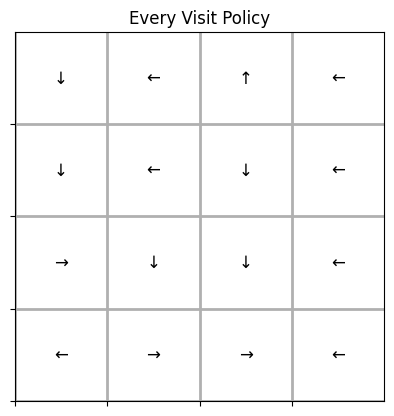

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_policy(q_table, grid_size=(4, 4), title='Policy', save_path=None):
    """
    Plots the policy learned by the Q-table on a grid using text labels for directions.

    Parameters:
        q_table (numpy.ndarray): The Q-table from which to derive the policy.
        grid_size (tuple): The size of the grid representing the environment (default is (4, 4)).
    """
    # Define direction labels
    direction_labels = {
        0: '←',  # left
        1: '↓',  # down
        2: '→',  # right
        3: '↑'   # up
    }

   
    policy = np.argmax(q_table, axis=1).reshape(grid_size)
    
    # Set up the grid
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(grid_size[1]))
    ax.set_yticks(np.arange(grid_size[0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Create grid
    ax.grid(which='both', linestyle='-', linewidth=2)
    
    # Plot direction labels
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            action = policy[i, j]
            direction = direction_labels[action]
            ax.text(j + 0.5, grid_size[0] - i - 0.5, direction, 
                    ha='center', va='center', fontsize=12, color='black')

    # Set the aspect of the plot to equal
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlim(0, grid_size[1])
    ax.set_ylim(0, grid_size[0])
    plt.savefig(save_path)
    plt.show()

# Usage example:
if __name__ == "__main__":
    # Assuming you have already saved your Q-tables as 'MC_tables.npy'
    FV_q_table = np.load('ON/models/FV_MC_Q.npy', allow_pickle=True)
    EV_q_table = np.load('ON/models/FV_MC_Q.npy', allow_pickle=True)
    
    plot_policy(FV_q_table, title='First Visit Policy', save_path='ON/imgs/FV_policy.png')
    plot_policy(EV_q_table, title='Every Visit Policy', save_path='ON/imgs/EV_policy.png')


# Codice con controllo sulla convergenza

In [ ]:
#CODICE SISTEMATO
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# Create the environment
def create_env(slippery):
    return gym.make('FrozenLake-v1', is_slippery=slippery)

# Initialize Q-table
def initialize_q_table(env):
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    return np.zeros((number_of_states, number_of_actions))

# Decay function for epsilon
def decay_function(episode, total_train_episodes, min_epsilon=0.01):
    return max(min_epsilon, min(1.0, 1.0 - np.log10((episode + 1) / (total_train_episodes * 0.1))))

# Choose action based on epsilon-greedy policy
def choose_action(q_table, state, epsilon, env):
    if np.random.random() <= epsilon:
        return env.action_space.sample()  # Exploration
    else:
        return np.argmax(q_table[state])  # Exploitation

# Generate an episode
def Generate_episode(epsilon, q_table, env, max_env_steps):
    state = env.reset()
    total_reward = 0
    done = False
    trajectory = []
    
    for step in range(max_env_steps):
        if isinstance(state, tuple):
            state = state[0]

        action = choose_action(q_table, state, epsilon, env)
        new_state, reward, done, info, _ = env.step(action)
        trajectory.append([state, action, reward])
        state = new_state
        total_reward += reward
        if done:
            break
    
    return trajectory, total_reward

def Monte_Carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon, first_visit, number):
    q_table = initialize_q_table(env)
    q_table_sum = np.zeros_like(q_table)  # To calculate the sum of the Q-tables
    q_table_square_sum = np.zeros_like(q_table)  # To calculate the square sum of the Q-tables
    visits_counter = np.zeros_like(q_table)
    rewards = []
    success_counter = 0

    max_env_steps = env.spec.max_episode_steps
    stop = False

    for episode in range(total_train_episodes):
        if not stop:
            epsilon = decay_function(episode, total_train_episodes, min_epsilon)
            trajectory, total_reward = Generate_episode(epsilon, q_table, env, max_env_steps)
            if total_reward == 1:
                success_counter += 1

            G = 0
            visited_states_actions = set()

            for t in reversed(range(len(trajectory))):
                state, action, reward = trajectory[t]
                G = gamma * G + reward

                if isinstance(state, dict):
                    state = state.get('state_key', 0)

                if isinstance(state, tuple):
                    state = state[0]

                # Update Q-table
                state_action = (state, action)
                if first_visit and state_action not in visited_states_actions:
                    visited_states_actions.add(state_action)
                    visits_counter[state, action] += 1
                    q_table[state, action] += (G - q_table[state, action]) / visits_counter[state, action]
                elif not first_visit:
                    visits_counter[state, action] += 1
                    q_table[state, action] += (G - q_table[state, action]) / visits_counter[state, action]

            # Update sum and squared sum for variance calculation
            q_table_sum += q_table
            q_table_square_sum += q_table ** 2

            if episode % 50 == 0:
                rewards.append(total_reward)

            if success_counter == 10:
                stop = True
                # Handle file logging here as per original function.

    # Compute the mean and variance at the end
    mean_q_table = q_table_sum / total_train_episodes
    mean_square_q_table = q_table_square_sum / total_train_episodes
    variance_q_table = mean_square_q_table - (mean_q_table ** 2)

    # Compute row-wise variance
    row_wise_variance = np.var(q_table, axis=1)

    # return q_table, row_wise_variance, rewards
    return q_table, variance_q_table, rewards

# Additional functions like initialize_q_table, decay_function, and Generate_episode need to be defined as well.



# Plotting the training rewards
def plot_rewards(rewards, title, save_path):
    x = np.linspace(0, len(rewards) * 50, len(rewards))
    plt.plot(x, rewards, label='Monte Carlo')
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.savefig(save_path)
    plt.show()

# Testing the policy
def test_policy(env, q_table, num_episodes):
    rewards = []
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(num_episodes):
        state = env.reset()
        total_rewards = 0
        done = False
        
        for step in range(max_env_steps):
            if isinstance(state, tuple):
                state = state[0]

            action = np.argmax(q_table[state])
            state, reward, done, info, _ = env.step(action)
            total_rewards += reward
            env.render()
            if done:
                env.render()
                break
        
        rewards.append(total_rewards)
        print(f"Episode {episode}, reward {total_rewards}")
    
    print(f"Average score: {np.mean(rewards)}")
    
    
def plot_variance_history(variance_history, save_path):
    mean_variance_over_episodes = np.mean(variance_history, axis=(1, 2))  # Media della varianza su tutte le celle
    plt.plot(mean_variance_over_episodes)
    plt.title('Mean Q-Table Variance Over Episodes')
    plt.xlabel('Episodes')
    plt.ylabel('Variance')
    plt.savefig(save_path)
    plt.show()

In [ ]:
# Main code
if __name__ == "__main__":
    n_times = 100 #10 if is_slippery=True
    total_train_episodes = 200 #50000 if is_slippery=True
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01
    slippery = False
    first_visit = False
    MC_tables = []
    MC_rewards = []
    MC_variances = []
    env = create_env(slippery)
    variance_history = np.zeros((total_train_episodes, env.observation_space.n, env.action_space.n))

    for number in range(n_times):
        print(f"\n ********** Training number {number} ********* \n")
        #q_table, rewards = Monte_Carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon, first_visit, number) 
        q_table, variance_q_table, rewards = Monte_Carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon, first_visit, number)
        # q_table, row_wise_variance, rewards = Monte_Carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon, first_visit, number)
        MC_tables.append(q_table)
        MC_rewards.append(rewards)
        MC_variances.append(variance_q_table)
    
    print(f"\n\n *** MC VARIANCES ** \n\n {MC_variances}")
    # Calcolo della varianza media finale per tutte le Q-tables
    final_variance = np.mean(MC_variances, axis=0)
    
    # Salva la varianza finale della Q-table
    save_path_var = 'final/on/every_visit/models/q_table_variance.npy'
    np.save(save_path_var, final_variance)
    
    print("Varianza finale della Q-table salvata con successo.")

    # we perform the mean of the rewards and the Q-tables to reduce variance
    #MC_mean = np.mean(np.array(MC_rewards), axis=0)
    MC_mean_table = np.mean(np.array(MC_tables), axis=0)
    save_path_rw = 'final/on/every_visit/imgs/results_MC_ON_TAB_rw.png'  # Adding .npy to this path
    save_path_mc = 'final/on/every_visit/models/table_MC_ON_TAB.npy'
    
    #np.save(save_path_rw, MC_mean)  # Save the mean rewards
    np.save(save_path_mc, MC_mean_table)  # Save the mean Q-table
    
    # plot_rewards(MC_mean, 'Monte Carlo', save_path_rw)
    
    # Traccia la varianza media delle celle della Q-table
    #save_path_var = 'final/on/every_visit/imgs/q_table_variance_over_time.png'
    #plot_variance_history(variance_history, save_path_var)
    
    # Load Q-tables and test
    q_table = np.load(save_path_mc, allow_pickle=True)
    env = gym.make('FrozenLake-v1', is_slippery=slippery, render_mode="human")
    test_policy(env, q_table, num_episodes=1)
    env.close()



 ********** Training number 0 ********* 


 ********** Training number 1 ********* 


 ********** Training number 2 ********* 


 ********** Training number 3 ********* 


 ********** Training number 4 ********* 


 ********** Training number 5 ********* 


 ********** Training number 6 ********* 


 ********** Training number 7 ********* 


 ********** Training number 8 ********* 


 ********** Training number 9 ********* 


 ********** Training number 10 ********* 


 ********** Training number 11 ********* 


 ********** Training number 12 ********* 


 ********** Training number 13 ********* 


 ********** Training number 14 ********* 


 ********** Training number 15 ********* 


 ********** Training number 16 ********* 


 ********** Training number 17 ********* 


 ********** Training number 18 ********* 


 ********** Training number 19 ********* 


 ********** Training number 20 ********* 


 ********** Training number 21 ********* 


 ********** Training number 22 ********* 

In [ ]:
print("Row-wise variance of Q-table:")
print(row_wise_variance)
log_variance = np.where(row_wise_variance > 0, np.log(row_wise_variance), 0)
print(log_variance)

Row-wise variance of Q-table:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/var/folders/f0/hxp6cbfd0pg58t2w6q4y09qr0000gr/T/ipykernel_69760/1850041636.py:3: RuntimeWarning: divide by zero encountered in log
  log_variance = np.where(row_wise_variance > 0, np.log(row_wise_variance), 0)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Definizione del percorso del file
file_path = 'final/on/every_visit/convergence_log.txt'

# Lettura e parsing del file
data = []
with open(file_path, 'r') as file:
    for line in file:
        parts = line.strip().split(':')
        exp_number = int(parts[0].split()[-1])
        episodes = int(parts[2].split()[0])
        epsilon = float(parts[3].strip())
        data.append({'Experiment Number': exp_number, 'Episodes to Convergence': episodes, 'Epsilon at Convergence': epsilon})

# Creazione di un DataFrame
df = pd.DataFrame(data)

# Grafico 1: Distribuzione degli episodi necessari per la convergenza
plt.figure(figsize=(10, 6))
plt.hist(df['Episodes to Convergence'], bins=20, color='blue', alpha=0.7)
plt.title('Distribuzione degli episodi necessari per la convergenza')
plt.xlabel('Episodi')
plt.ylabel('Frequenza')
plt.grid(True)
#plt.show()

# Grafico 2: Distribuzione di epsilon al momento della convergenza
plt.figure(figsize=(10, 6))
plt.hist(df['Epsilon at Convergence'], bins=20, color='green', alpha=0.7)
plt.title('Distribuzione di epsilon al momento della convergenza')
plt.xlabel('Epsilon')
plt.ylabel('Frequenza')
plt.grid(True)
#plt.show()

# Grafico 3: Frequenza di raggiungimento della convergenza
plt.figure(figsize=(10, 6))
convergence_count = df['Experiment Number'].nunique()
plt.bar(['Convergenza Raggiunta', 'Convergenza Non Raggiunta'], [convergence_count, 50 - convergence_count], color='red', alpha=0.7)
plt.title('Frequenza di raggiungimento della convergenza su 50 esperimenti')
plt.ylabel('Numero di Esperimenti')
#plt.show()


ValueError: invalid literal for int() with base 10: 'number'

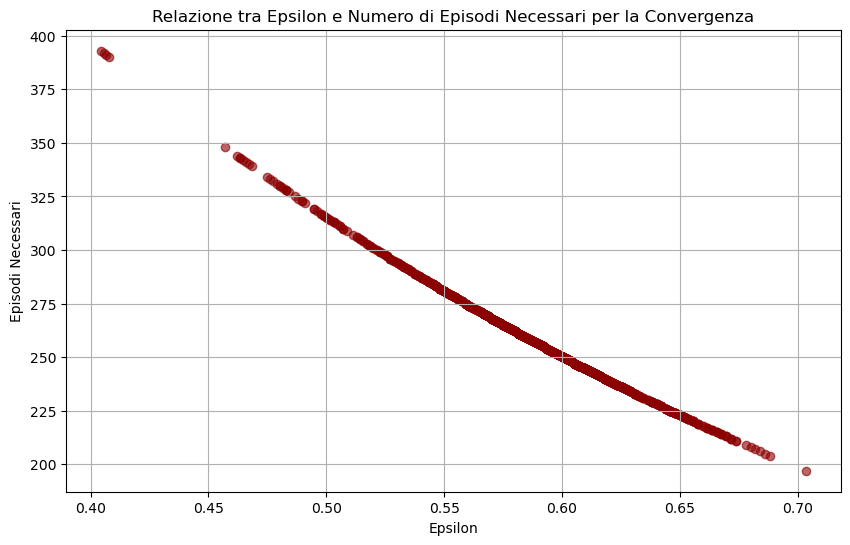

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Supponiamo che il DataFrame 'df' sia già stato creato dal codice precedente
# Grafico di dispersione tra epsilon e numero di episodi necessari per la convergenza
plt.figure(figsize=(10, 6))
plt.scatter(df['Epsilon at Convergence'], df['Episodes to Convergence'], color='darkred', alpha=0.6)
plt.title('Relazione tra Epsilon e Numero di Episodi Necessari per la Convergenza')
plt.xlabel('Epsilon')
plt.ylabel('Episodi Necessari')
plt.grid(True)
plt.show()


In [ ]:
def plot_rewards(rewards, title, save_path):
    x = np.arange(len(rewards))
    plt.figure(figsize=(10, 6))
    plt.plot(x, rewards, label='Monte Carlo')
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.savefig(save_path)
    plt.show()

def plot_epsilon_decay(total_train_episodes, min_epsilon, save_path):
    episodes = np.arange(total_train_episodes)
    epsilon_values = [decay_function(episode, total_train_episodes, min_epsilon) for episode in episodes]
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, epsilon_values, label='Epsilon Decay')
    plt.title('Epsilon Decay Over Episodes')
    plt.xlabel('Episodes')
    plt.ylabel('Epsilon')
    plt.legend()
    plt.savefig(save_path)
    plt.show()

def plot_variance_history(variance_history, save_path):
    mean_variance_over_episodes = np.mean(variance_history, axis=(1, 2))  # Media della varianza su tutte le celle
    plt.figure(figsize=(10, 6))
    plt.plot(mean_variance_over_episodes)
    plt.title('Mean Q-Table Variance Over Episodes')
    plt.xlabel('Episodes')
    plt.ylabel('Variance')
    plt.savefig(save_path)
    plt.show()

def plot_convergence_times(convergence_times, save_path):
    plt.figure(figsize=(10, 6))
    plt.hist(convergence_times, bins=20, edgecolor='black')
    plt.title('Histogram of Convergence Times')
    plt.xlabel('Episodes to Converge')
    plt.ylabel('Frequency')
    plt.savefig(save_path)
    plt.show()

def plot_action_distribution(q_table, env, save_path):
    num_states = q_table.shape[0]
    num_actions = q_table.shape[1]
    action_counts = np.zeros((num_states, num_actions))
    
    for state in range(num_states):
        best_action = np.argmax(q_table[state])
        action_counts[state, best_action] += 1

    plt.figure(figsize=(12, 8))
    plt.imshow(action_counts, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Action Distribution Heatmap')
    plt.xlabel('Actions')
    plt.ylabel('States')
    plt.savefig(save_path)
    plt.show()

def plot_final_rewards(final_rewards, save_path):
    plt.figure(figsize=(10, 6))
    plt.boxplot(final_rewards)
    plt.title('Distribution of Final Rewards')
    plt.xlabel('Experiments')
    plt.ylabel('Final Reward')
    plt.savefig(save_path)
    plt.show()

def plot_q_values_over_time(q_table_history, save_path):
    max_q_values = [np.max(q_table) for q_table in q_table_history]
    min_q_values = [np.min(q_table) for q_table in q_table_history]
    
    plt.figure(figsize=(10, 6))
    plt.plot(max_q_values, label='Max Q-Value')
    plt.plot(min_q_values, label='Min Q-Value')
    plt.title('Max and Min Q-Values Over Time')
    plt.xlabel('Episodes')
    plt.ylabel('Q-Value')
    plt.legend()
    plt.savefig(save_path)
    plt.show()


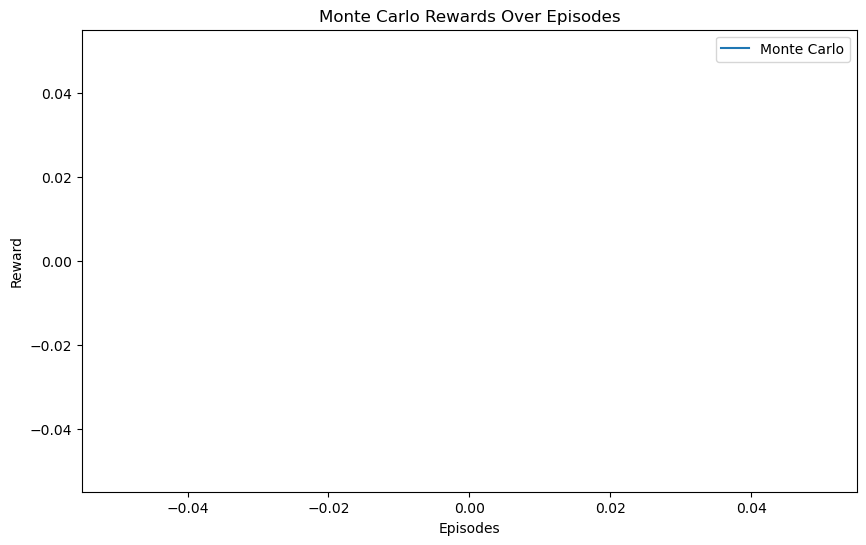

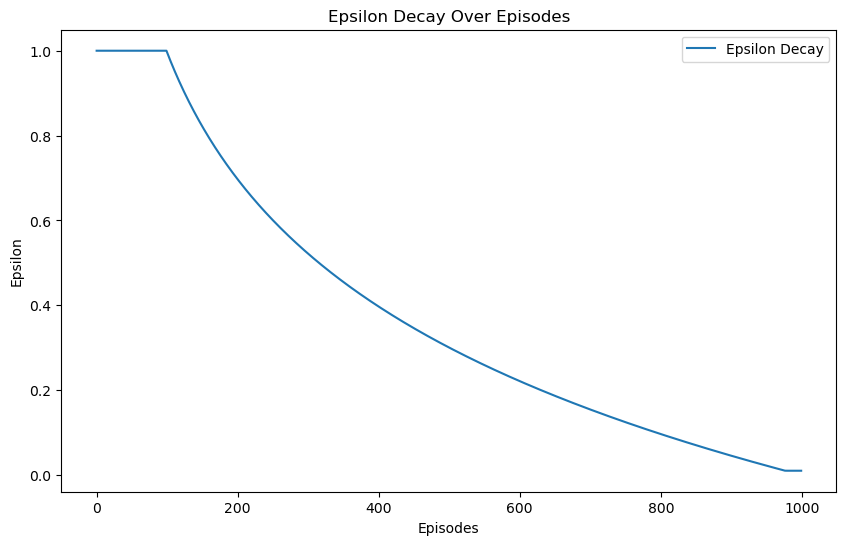

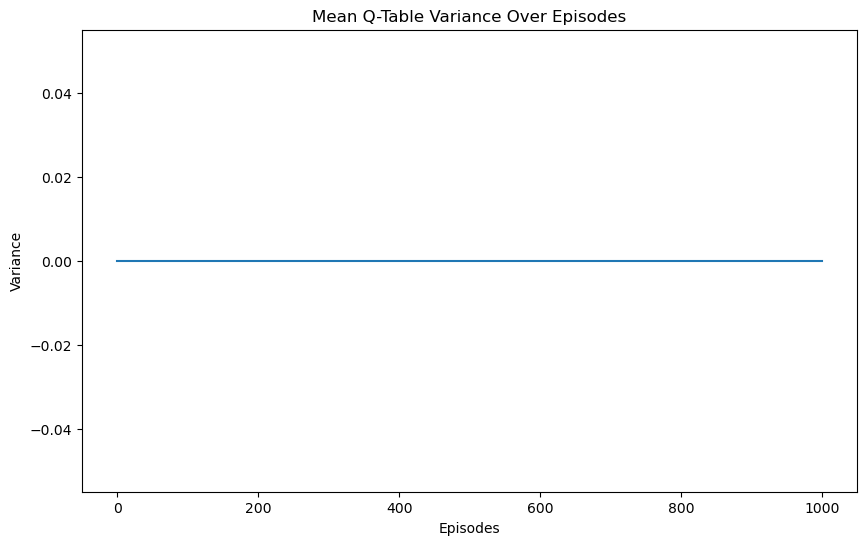

NameError: name 'convergence_times' is not defined

In [ ]:
"""# Salva e traccia i grafici
    # Calcola media delle ricompense
MC_mean_rewards = np.mean(MC_rewards, axis=0)
plot_rewards(MC_mean_rewards, 'Monte Carlo Rewards Over Episodes', 'ON/imgs/results_MC_ON_TAB_rw.png')
plot_epsilon_decay(total_train_episodes, min_epsilon, 'ON/imgs/epsilon_decay.png')
plot_variance_history(variance_history / n_times, 'ON/imgs/q_table_variance_over_time.png')
plot_convergence_times(convergence_times, 'ON/imgs/convergence_times.png')
plot_action_distribution(np.mean(MC_tables, axis=0), env, 'ON/imgs/action_distribution.png')
plot_final_rewards(MC_rewards, 'ON/imgs/final_rewards.png')
plot_q_values_over_time(q_table_history, 'ON/imgs/q_values_over_time.png')"""